In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import time
import matplotlib
import glob
import shutil
%matplotlib inline

/Users/qasimiqbal/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (64, 64))
    image = image[None, ...]
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(image)
    return image

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    return parts[-1]

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img)

    return img, label

In [129]:
original = pathlib.Path('./data/tiny-imagenet-200/train/')
new = pathlib.Path('./data/tiny-imagenet-200/b_train/')
shutil.copytree(original, new)

PosixPath('data/tiny-imagenet-200/b_train')

In [15]:
data_dir = pathlib.Path('./data/tiny-imagenet-200/train/')
CLASSES = sorted([item.name for item in data_dir.glob('*')])
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/images/*.JPEG'), shuffle=False)
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [16]:
for i, elem in enumerate(list_ds):
    if i > 0:
        break
    print (elem)

tf.Tensor(b'data/tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG', shape=(), dtype=string)


In [17]:
# dict that is keyed by image name and returns bounding box coordinates
bounding_boxes = {}

def insert_bb_to_dict(file_path, d=bounding_boxes):
    file = open(file_path, 'r')
    line = file.readline()
    while line:
        tokens = line.split()
        image = tokens[0]
        coords = tuple(tokens[1:])
        d[image] = coords
        line = file.readline()
    file.close()
    return file_path

In [18]:
text_files = glob.glob(str(data_dir/'*/*_boxes.txt'))

In [19]:
for text_file in text_files:
    insert_bb_to_dict(text_file)

In [20]:
len(bounding_boxes)

100000

In [21]:
IMG_HEIGHT, IMG_WIDTH = 64, 64

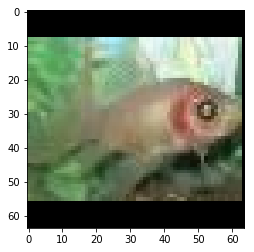

In [22]:
num_to_check
for idx, (image, label) in enumerate(labeled_ds):
    if idx > num_to_check - 1:
        break
    image_name = label.numpy().decode('utf8')
    
    label = str(label.numpy())
    name = label.split('.')[0][2:]
    class_name = label.split('_')[0][2:]
#     print(label, name, class_name)
    
    coord = bounding_boxes[image_name]
    offset_height = int(coord[1]) # yminn
    offset_width = int(coord[0]) # xminn
    target_height = int(coord[3]) - offset_height
    target_width = int(coord[2]) - offset_width
#     print(offset_height, offset_width, target_height, target_width)
    cropped_image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)
#     print(image_name)
    p_offset_height = (IMG_HEIGHT - target_height) // 2
    p_offset_width = (IMG_WIDTH - target_width) // 2
    padded_image = tf.image.pad_to_bounding_box(cropped_image, p_offset_height, p_offset_width, IMG_HEIGHT, IMG_WIDTH)
    plt.imshow(cropped_image)
    plt.imshow(padded_image)

In [33]:
bad_target = []

In [34]:
start_time = time.time()
IMG_HEIGHT, IMG_WIDTH = 64, 64
counter = 1
for image, label in labeled_ds:
    image_name = label.numpy().decode('utf8')
    coord = bounding_boxes[image_name]

    label = str(label.numpy())
    name = label.split('.')[0][2:]
    class_name = label.split('_')[0][2:]

    offset_height = int(coord[1]) #yminn
    offset_width = int(coord[0]) #xminn
    target_height = int(coord[3]) - offset_height
    target_width = int(coord[2]) - offset_width
    if target_height <= 0 or target_width <= 0:
        bad_target.append(name)
        continue

    cropped_image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)
    p_offset_height = (IMG_HEIGHT - target_height) // 2
    p_offset_width = (IMG_WIDTH - target_width) // 2
    padded_image = tf.image.pad_to_bounding_box(cropped_image, p_offset_height, p_offset_width, IMG_HEIGHT, IMG_WIDTH)
    try:
        matplotlib.image.imsave('./data/tiny-imagenet-200/b_train/{}/images/{}.JPEG'.format(class_name, name + 'bb'), padded_image)
    except:
        try:
            padded_image = preprocess(padded_image)
        except:
            print('Preprocessing didn\'t work')
            bad_saving.append(name)
        
    if counter % 1000 == 0:
        print('\ntotal time so far:', time.time() - start_time)
        print('cropped images created:', counter)
    
    counter += 1
    
print('\ntotal time: ', time.time() - start_time)


total time so far: 6.308464288711548
cropped images created: 1000

total time so far: 11.55283808708191
cropped images created: 2000

total time so far: 17.84080410003662
cropped images created: 3000

total time so far: 24.13656497001648
cropped images created: 4000

total time so far: 30.27928924560547
cropped images created: 5000

total time so far: 35.34015512466431
cropped images created: 6000

total time so far: 40.51683020591736
cropped images created: 7000

total time so far: 44.98883414268494
cropped images created: 8000

total time so far: 49.59866809844971
cropped images created: 9000

total time so far: 54.06676125526428
cropped images created: 10000

total time so far: 58.77155518531799
cropped images created: 11000

total time so far: 63.520432233810425
cropped images created: 12000

total time so far: 68.21648931503296
cropped images created: 13000

total time so far: 72.8842523097992
cropped images created: 14000

total time so far: 77.72857427597046
cropped images crea

In [36]:
len(bad_target)

434

In [37]:
bad_target

['n01443537_425',
 'n01768244_309',
 'n01910747_16',
 'n01910747_229',
 'n01910747_347',
 'n01944390_173',
 'n01983481_490',
 'n02002724_196',
 'n02002724_273',
 'n02056570_233',
 'n02056570_387',
 'n02165456_164',
 'n02206856_102',
 'n02233338_150',
 'n02281406_329',
 'n02395406_101',
 'n02403003_260',
 'n02410509_288',
 'n02410509_31',
 'n02423022_101',
 'n02423022_434',
 'n02437312_157',
 'n02666196_146',
 'n02669723_364',
 'n02699494_125',
 'n02699494_141',
 'n02699494_165',
 'n02699494_188',
 'n02699494_248',
 'n02699494_270',
 'n02699494_345',
 'n02699494_414',
 'n02699494_466',
 'n02699494_472',
 'n02699494_67',
 'n02699494_88',
 'n02788148_496',
 'n02793495_84',
 'n02795169_269',
 'n02802426_1',
 'n02802426_109',
 'n02802426_114',
 'n02802426_120',
 'n02802426_123',
 'n02802426_156',
 'n02802426_164',
 'n02802426_175',
 'n02802426_179',
 'n02802426_193',
 'n02802426_21',
 'n02802426_224',
 'n02802426_232',
 'n02802426_233',
 'n02802426_253',
 'n02802426_262',
 'n02802426_275',
